In [1]:
from mlp import MLP
from train_test import train_model, test_model
import torch
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
import time

In [2]:
print(torch.version)
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.get_arch_list())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

<module 'torch.version' from 'C:\\Users\\Maxwell\\AppData\\Roaming\\Python\\Python310\\site-packages\\torch\\version.py'>
2.0.0+cu118
11.8
['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'compute_37']
1
0


In [3]:
data_path = '../data/release/native/' # '../data/release/template/' for template space prediction
task = 'sex' # 'birth_age' for birth age prediction

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 32
epochs = 2000
patience = 200 # for early stopping
lr = 0.001


cuda


In [4]:
#check if datapath is right
file_list = os.listdir(data_path)
print('File num: ', len(file_list))

File num:  1218


In [5]:
train_ids = np.loadtxt('indices/' + task + '_train.txt', dtype='str')
val_ids = np.loadtxt('indices/' + task + '_validation.txt', dtype='str')
test_ids = np.loadtxt('indices/' + task + '_test.txt', dtype='str')

mirror_index = np.load('mirror_index.npy') # mirrors right hemispheres to match with left hemispheres

df = pd.read_csv("combined.csv")

df.insert(0, "ID", "sub-" + df["participant_id"] + "_" + "ses-" + df["session_id"].apply(str))
df.drop("participant_id", axis=1, inplace=True)
df.drop("session_id", axis=1, inplace=True)

df

FileNotFoundError: indices/sex_train.txt not found.

In [ ]:
def get_data(data_path, task, ids):
    xs = []
    ys = []
    check = 0
    for _id in ids:
        try:
            img_L = nib.load(data_path + _id + '_left.shape.gii')
            x_L = np.stack(img_L.agg_data(), axis=1)
            for i in range(4):
                # replaces the zeros of the medial wall cut area with mean values
                x_L[:, i][x_L[:, i] == 0] = np.mean(x_L[:, i][x_L[:, i] != 0]) # i corresponds to what exactly?
                #let's see; 
                #if check < 5:
                    #print("Let's see what x_L is: ", x_L)
                    #check += 1
            xs.append(x_L.astype(np.float32))
            y = np.array([df.loc[df['ID'] == _id, task].item()])
            ys.append(y.astype(np.float32))
            img_R = nib.load(data_path + _id + '_right.shape.gii')
            x_R = np.stack(img_R.agg_data(), axis=1)[mirror_index] # mirroring
            for i in range(4):
                # replaces the zeros of the medial wall cut area with mean values
                x_R[:, i][x_R[:, i] == 0] = np.mean(x_R[:, i][x_R[:, i] != 0])
            xs.append(x_R.astype(np.float32))
            y = np.array([df.loc[df['ID'] == _id, task].item()])
            ys.append(y.astype(np.float32))
        except:
            print('train set element %s does not exist' % _id)
    return xs, ys

train_xs, train_ys = get_data(data_path, task, train_ids)
val_xs, val_ys = get_data(data_path, task, val_ids)
test_xs, test_ys = get_data(data_path, task, test_ids)


train set element sub-CC00061XX04_ses-13300 does not exist
train set element sub-CC00084XX11_ses-31201 does not exist
train set element sub-CC00143AN12_ses-47501 does not exist
train set element sub-CC00170XX06_ses-56100 does not exist
train set element sub-CC00217XX11_ses-73700 does not exist
train set element sub-CC00221XX07_ses-75000 does not exist
train set element sub-CC00291XX12_ses-93100 does not exist
train set element sub-CC00307XX10_ses-98800 does not exist
train set element sub-CC00341XX12_ses-108000 does not exist
train set element sub-CC00319XX14_ses-117300 does not exist
train set element sub-CC00439XX19_ses-132100 does not exist
train set element sub-CC00442XX14_ses-133300 does not exist
train set element sub-CC00371XX09_ses-134700 does not exist
train set element sub-CC00468XX15_ses-139100 does not exist
train set element sub-CC00501XX06_ses-146500 does not exist
train set element sub-CC00227XX13_ses-92100 does not exist


In [ ]:
#np_test = np.array([np.array(xi) for xi in train_xs])
# vstack makes it into a 2d array when I still need 3d...
#np_test.shape


In [ ]:
length_list = [len(inner_list) for inner_list in train_xs]
mode = max(set(length_list), key=length_list.count)
#offsize_list = [size for size in length_list if size != mode ]#
#print(length_list[0:5])
#print(max(length_list))
#print(min(length_list))
#print(offsize_list)
offsize_list_ind = [i for i in range(len(length_list)) if length_list[i] != mode]
##print(offsize_list_ind)
only_correct_sized = [train_xs[i] for i in range(len(length_list)) if length_list[i] == mode]

In [ ]:
np.array(train_xs, dtype=object)[0].shape

(40962, 4)

In [ ]:
train_xs = np.transpose(only_correct_sized, axes=[1, 2, 0])

In [ ]:
# data standardization

#why doesn't this match?
#train_xs = np.transpose(np.array(train_xs, dtype=object), axes=[1, 2, 0])
means  = np.mean(np.mean(train_xs, axis=2), axis=0) # means of the 4 channels in the train set
stds  = np.std(np.std(train_xs, axis=2), axis=0) # stds of the 4 channels in the train set
train_xs = (train_xs - means.reshape(1, means.shape[0], 1)) / stds.reshape(1, means.shape[0], 1)
train_xs = np.transpose(train_xs, axes=[2, 0, 1])

val_xs = np.transpose(val_xs, axes=[1, 2, 0])
val_xs = (val_xs - means.reshape(1, means.shape[0], 1)) / stds.reshape(1, means.shape[0], 1)
val_xs = np.transpose(val_xs, axes=[2, 0, 1])

test_xs = np.transpose(test_xs, axes=[1, 2, 0])
test_xs = (test_xs - means.reshape(1, means.shape[0], 1)) / stds.reshape(1, means.shape[0], 1)
test_xs = np.transpose(test_xs, axes=[2, 0, 1])

In [ ]:
train_subset = [(torch.from_numpy(x), torch.from_numpy(y)) for x, y in zip(train_xs, train_ys)]

val_subset = [(torch.from_numpy(x), torch.from_numpy(y)) for x, y in zip(val_xs, val_ys)]

test_subset = [(torch.from_numpy(x), torch.from_numpy(y)) for x, y in zip(test_xs, test_ys)]


In [ ]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=len(val_subset), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)

model = MLP(4, [16, 16, 16, 16], 1, device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)
print('Number of parameters: ', sum(p.numel() for p in model.parameters() if p.requires_grad))


MLP(
  (lin1): Linear(in_features=4, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin4): Linear(in_features=16, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin5): Linear(in_features=16, out_features=16, bias=True)
  (lin6): Linear(in_features=16, out_features=1, bias=True)
)
Number of parameters:  1313


In [ ]:
train_losses = []
val_losses = []
test_losses = []

best_val_index = -1

training_start_time = time.time()
time_array = []
time_array.append(training_start_time)



for epoch in range(epochs):
    train_loss = train_model(train_loader, model, optimizer).cpu().detach().numpy()
    val_loss = test_model(val_loader, model).cpu().detach().numpy()
    test_loss = test_model(test_loader, model).cpu().detach().numpy()
    new_min = " "
    if epoch > 0:
        if val_losses[best_val_index] > val_loss:
            new_min = "*"
            best_val_index = epoch
            torch.save(model.state_dict(), 'MLP_sex_1.pt') #this thankfully already saves the best val loss model
        #temporarily disable early stoppage
        # early stopping is called
        if len(val_losses) - best_val_index > patience:
            print ("Early stopping, best val loss and index:")
            print(val_losses[best_val_index], best_val_index)
            break
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    print(new_min, "Epoch: %d, train loss: %1.3f, val loss: %1.3f, test loss: %1.3f" % (epoch, train_loss, val_loss, test_loss))
    time_array.append(time.time())

    


  Epoch: 0, train loss: 38.371, val loss: 38.204, test loss: 38.025
* Epoch: 1, train loss: 38.150, val loss: 37.859, test loss: 37.725
* Epoch: 2, train loss: 37.787, val loss: 37.413, test loss: 37.267
* Epoch: 3, train loss: 37.202, val loss: 36.900, test loss: 36.723
* Epoch: 4, train loss: 36.353, val loss: 36.077, test loss: 35.832
* Epoch: 5, train loss: 35.352, val loss: 34.953, test loss: 34.723
* Epoch: 6, train loss: 34.338, val loss: 33.926, test loss: 33.684
* Epoch: 7, train loss: 33.411, val loss: 33.046, test loss: 32.801
* Epoch: 8, train loss: 32.602, val loss: 32.283, test loss: 32.035
* Epoch: 9, train loss: 31.866, val loss: 31.605, test loss: 31.353
* Epoch: 10, train loss: 31.214, val loss: 30.980, test loss: 30.727
* Epoch: 11, train loss: 30.601, val loss: 30.402, test loss: 30.146
* Epoch: 12, train loss: 30.036, val loss: 29.856, test loss: 29.599
* Epoch: 13, train loss: 29.486, val loss: 29.333, test loss: 29.076
* Epoch: 14, train loss: 28.983, val loss: 2

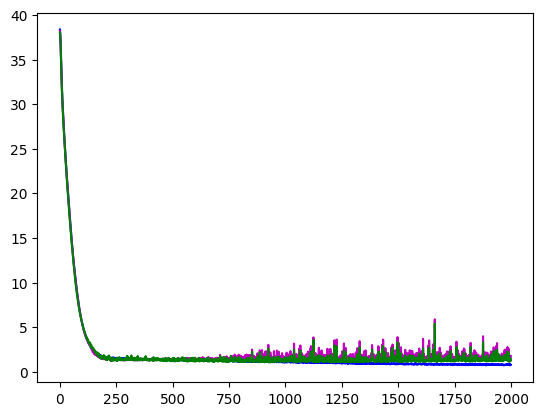

In [ ]:
plt.plot(train_losses, color='b')
plt.plot(val_losses, color='m')
plt.plot(test_losses, color='g')
plt.show()

In [ ]:
#Retrieve best val loss
best_val_loss = val_losses[best_val_index]


In [ ]:
#timing recordings

end_time = time.time()
total_train_time = end_time - training_start_time
time_differences = []
for i in range(len(time_array) - 1):
    last_time = time_array[i]
    this_time = time_array[i + 1]
    diff = this_time - last_time
    time_differences.append(diff)
    

average_time = total_train_time / len(time_array)

print("Total time: ", round(total_train_time / 60, 2), " mins")
print("Average training time: ", round(average_time, 2), " seconds")
print("Longest training time: ", round(max(time_differences), 2), "seconds")
print("Shortest training time: ", round(min(time_differences), 2), "seconds")
print("\nBest Val Loss: ", best_val_loss, " at epoch num ", best_val_index)

Total time:  30.89  mins
Average training time:  0.93  seconds
Longest training time:  2.62 seconds
Shortest training time:  0.91 seconds

Best Val Loss:  1.2674819  at epoch num  283


In [ ]:
from train_test import display_test_stats

In [ ]:
# Check against a saved version of the model
model_choice = 'MLP_sex_1.pt'
model = MLP(4, [16, 16, 16, 16], 1, device=device)
model.load_state_dict(torch.load(model_choice))
model.eval()


MLP(
  (lin1): Linear(in_features=4, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin4): Linear(in_features=16, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin5): Linear(in_features=16, out_features=16, bias=True)
  (lin6): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
test_loss, predictions, truths, mae = display_test_stats(val_loader, model)

print("Will this loss work: ", test_loss)
#print("Predictions: ", predictions, '\n')
print("test")
#print("Truths: ", truths)
print(mae)


This ran
Will this loss work:  tensor(1.2675, device='cuda:0')
test
tensor(1.2675, device='cuda:0')
